In [1]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

False

In [4]:
train_dir = "./dataset/train/"
test_dir = "./dataset/test/"
train_classa_dir = "./dataset/train/moire/"
train_classb_dir = "./dataset/train/no_moire/"
test_classa_dir = "./dataset/test/moire/"
test_classb_dir = "./dataset/test/no_moire/"

In [19]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [7]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 256
Test dataset size: 81
Class names: ['moire', 'no_moire']


# get model

In [33]:
model = models.resnet18(pretrained=True)
model

/Users/frederic.birwe/Library/Python/3.10/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/Users/frederic.birwe/Library/Python/3.10/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
num_features = model.fc.in_features 
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


In [36]:
num_features

512

In [13]:
# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

In [32]:
inputs.shape

torch.Size([9, 3, 224, 224])

In [35]:
model(inputs).shape

torch.Size([9, 1000])

# Train

In [14]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [15]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [17]:
import time

In [21]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0658 Acc: 51.9531% Time: 9.4345s
[Test #1] Loss: 0.0613 Acc: 53.0864% Time: 10.5576s
Epoch 1 running
[Train #2] Loss: 0.0612 Acc: 55.8594% Time: 18.1479s
[Test #2] Loss: 0.0622 Acc: 50.6173% Time: 19.0504s
Epoch 2 running
[Train #3] Loss: 0.0568 Acc: 60.9375% Time: 26.7049s
[Test #3] Loss: 0.0636 Acc: 48.1481% Time: 27.6197s
Epoch 3 running
[Train #4] Loss: 0.0555 Acc: 63.2812% Time: 35.3529s
[Test #4] Loss: 0.0650 Acc: 51.8519% Time: 36.2572s
Epoch 4 running
[Train #5] Loss: 0.0526 Acc: 69.1406% Time: 44.0839s
[Test #5] Loss: 0.0669 Acc: 50.6173% Time: 44.9883s
Epoch 5 running
[Train #6] Loss: 0.0519 Acc: 65.2344% Time: 52.5660s
[Test #6] Loss: 0.0676 Acc: 50.6173% Time: 53.4636s
Epoch 6 running
[Train #7] Loss: 0.0493 Acc: 73.0469% Time: 61.0856s
[Test #7] Loss: 0.0696 Acc: 50.6173% Time: 61.9860s
Epoch 7 running
[Train #8] Loss: 0.0481 Acc: 73.4375% Time: 69.9177s
[Test #8] Loss: 0.0703 Acc: 50.6173% Time: 70.9651s
Epoch 8 running
[Train #9] Loss: 

In [26]:
import plotly.express as px
import numpy as np

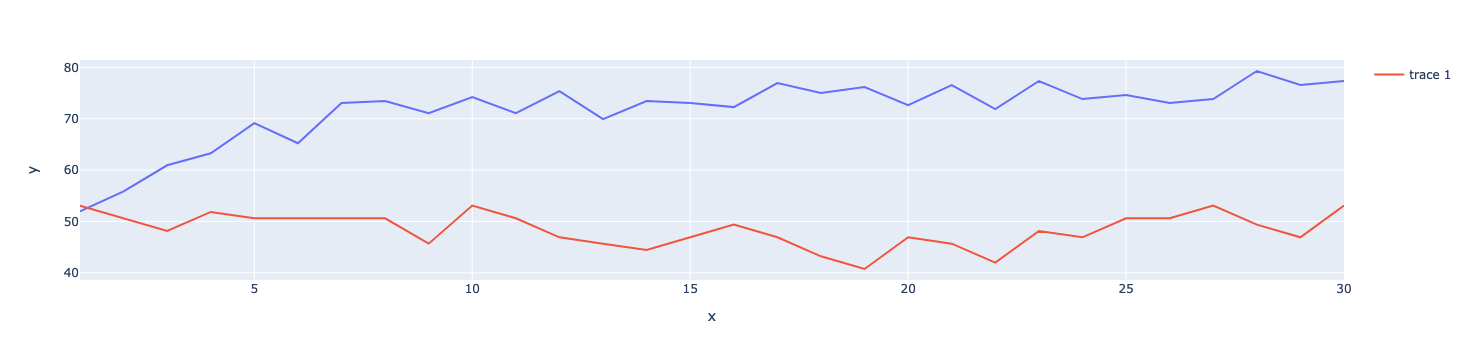

In [28]:
fig = px.line(
    x=np.arange(1,num_epochs+1),
    y=train_accuary
)

# Only thing I figured is - I could do this 
fig.add_scatter(
    x=np.arange(1,num_epochs+1),
    y=test_accuary
) # Not what is desired - need a line 

# Show plot 
fig.show()